In [25]:
import os
import sys
sys.path.append('../src/')
import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 101)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import cca_functions

# configurations
- follow the file selection dialog:
    - select microscopy folder in first step
    - select positions of the selected folder in second step
- repeat to add more positions to the analysis
- positions selected within one iteration of the dialog will be pooled together in the following analyses

In [26]:
data_dirs, positions = cca_functions.configuration_dialog()
file_names = [os.path.split(path)[-1] for path in data_dirs]
image_folders = [[os.path.join(data_dir, pos_str, 'Images') for pos_str in pos_list] for pos_list, data_dir in zip(positions, data_dirs)]
# determine available channels based on first(!) position.
# Warn user if one or more of the channels are not available for some positions
first_pos_files = os.listdir(os.path.join(data_dirs[0], positions[0][0], 'Images'))
channels, warn = cca_functions.find_available_channels(first_pos_files)

# load data and perform all needed calculations on image data

In [28]:
overall_df = cca_functions.calculate_downstream_data(
    file_names,
    image_folders,
    positions,
    channels, 
    force_recalculation=True)

Load files for MIA_KC_test_files, Position_2...


  2%|██                                                                                | 6/241 [00:00<00:04, 55.74it/s]

Number of cells in position: 18
Number of annotated frames in position: 241
Calculate regionprops on each frame based on Segmentation...


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 12.46it/s]


Saving calculated data for next time...
Load files for MIA_KC_test_files, Position_3...


  2%|██                                                                                | 6/241 [00:00<00:04, 55.31it/s]

Number of cells in position: 28
Number of annotated frames in position: 241
Calculate regionprops on each frame based on Segmentation...


  0%|                                                                                           | 0/28 [00:00<?, ?it/s]

Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 13.05it/s]


Saving calculated data for next time...
Load files for MIA_KC_test_files, Position_4...


  2%|██                                                                                | 6/241 [00:00<00:04, 52.37it/s]

Number of cells in position: 54
Number of annotated frames in position: 241
Calculate regionprops on each frame based on Segmentation...


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:15<00:00, 15.98it/s]


Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  8.58it/s]


Saving calculated data for next time...
Load files for MIA_KC_test_files, Position_5...


  4%|███▏                                                                              | 8/208 [00:00<00:02, 73.46it/s]

Number of cells in position: 42
Number of annotated frames in position: 208
Calculate regionprops on each frame based on Segmentation...


  0%|                                                                                           | 0/42 [00:00<?, ?it/s]

Calculate mean signal strength for every channel and cell...


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:04<00:00, 10.20it/s]

Saving calculated data for next time...


In [29]:
# Join on Cell_ID vs. relative_ID to later calculate columns like "daughter growth" or "mother-bud-signal-combined"
overall_df_rel = overall_df.copy()
overall_df = overall_df.merge(
    overall_df_rel,
    how='left',
    left_on=['frame_i', 'relative_ID', 'max_frame_pos', 'file', 'selection_subset', 'position', 'directory'],
    right_on=['frame_i', 'Cell_ID', 'max_frame_pos', 'file', 'selection_subset', 'position', 'directory'],
    suffixes = ('', '_rel')
)
overall_df['mCitrine_combined_amount_mother_bud'] = overall_df.apply(
    lambda x: x.loc['mCitrine_corrected_amount']+x.loc['mCitrine_corrected_amount_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else\
    x.loc['mCitrine_corrected_amount'],
    axis=1
)
overall_df['combined_mother_bud_volume'] = overall_df.apply(
    lambda x: x.loc['cell_vol_fl']+x.loc['cell_vol_fl_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else\
    x.loc['cell_vol_fl'],
    axis=1
)

In [30]:
# build dataframe grouped by phases
phase_grouped = overall_df.sort_values(
    'frame_i'
).groupby(
    ['Cell_ID', 'generation_num', 'cell_cycle_stage', 'relationship', 'position', 'file', 
     'max_frame_pos', 'selection_subset', 'max_t']
).agg(
    # perform some calculations relating to the whole phase:
    phase_area_growth=('cell_area_um2', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_volume_growth=('cell_vol_fl', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_area_at_beginning=('cell_area_um2', 'first'),
    phase_volume_at_beginning=('cell_vol_fl', 'first'),
    phase_volume_at_end=('cell_vol_fl', 'last'),
    phase_daughter_area_growth=('cell_area_um2_rel', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_daughter_volume_growth=('cell_vol_fl_rel', lambda x: x.iloc[-1]-x.iloc[0]),
    phase_length=('frame_i', lambda x: max(x)-min(x)),
    phase_begin = ('frame_i', min),
    phase_end = ('frame_i', max),
    phase_mCitrine_amount_at_beginning = ('mCitrine_corrected_amount', 'first'),
    phase_mCitrine_mean_at_beginning = ('mCitrine_corrected_mean', 'first'),
    phase_mCitrine_concentration_at_beginning = ('mCitrine_corrected_concentration', 'first'),
    phase_mCitrine_amount_comb_end = ('mCitrine_combined_amount_mother_bud', 'last'),
    phase_volume_at_end_combined = (('combined_mother_bud_volume'), 'last')
).reset_index()

# detect complete cell cycle phases and complete cell cycles
temp = np.logical_and(
    phase_grouped.phase_begin > 0,
    phase_grouped.phase_end < phase_grouped.max_frame_pos
)
# this or is for disappearing cells
complete_phase_indices = np.logical_and(
    temp,
    phase_grouped.phase_end < phase_grouped.max_t
)
phase_grouped['complete_phase'] = complete_phase_indices.astype(int)
no_of_compl_phases_per_cycle = phase_grouped.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
)['complete_phase'].transform('sum')
complete_cycle_indices = no_of_compl_phases_per_cycle == 2
phase_grouped['complete_cycle'] = complete_cycle_indices.astype(int)
# append phase-grouped data to overall_df
overall_df = overall_df.merge(
    phase_grouped,
    how='left',
    on=['Cell_ID', 'generation_num', 'cell_cycle_stage', 'relationship', 'position', 'file', 
        'max_frame_pos', 'selection_subset', 'max_t']
)

In [31]:
phase_grouped.sort_values(['position', 'file', 'Cell_ID']).head(15)

,Cell_ID,generation_num,cell_cycle_stage,relationship,position,file,max_frame_pos,selection_subset,max_t,phase_area_growth,phase_volume_growth,phase_area_at_beginning,phase_volume_at_beginning,phase_volume_at_end,phase_daughter_area_growth,phase_daughter_volume_growth,phase_length,phase_begin,phase_end,phase_mCitrine_amount_at_beginning,phase_mCitrine_mean_at_beginning,phase_mCitrine_concentration_at_beginning,phase_mCitrine_amount_comb_end,phase_volume_at_end_combined,complete_phase,complete_cycle
1,1,2,S,mother,Position_2,MIA_KC_test_files,240,0,240,1.134,6.044,31.072,120.390,126.433,13.707,45.706,25,0,25,505469.0,838.257,4198.605,689271.0,177.447,0,0
5,1,3,G1,mother,Position_2,MIA_KC_test_files,240,0,240,6.647,45.719,32.360,128.097,173.817,NaN,NaN,14,26,40,348895.0,555.565,2723.671,354678.0,173.817,1,1
9,1,3,S,mother,Position_2,MIA_KC_test_files,240,0,240,0.361,2.770,39.420,177.337,180.107,18.808,57.618,31,41,72,362238.0,473.514,2042.649,563949.0,237.897,1,1
13,1,4,G1,mother,Position_2,MIA_KC_test_files,240,0,240,-0.103,-0.643,40.399,181.898,181.255,0.618,1.057,6,73,79,310673.0,396.267,1707.948,338008.0,181.255,1,1
17,1,4,S,mother,Position_2,MIA_KC_test_files,240,0,240,-5.256,-31.147,40.656,182.997,151.850,21.075,70.965,27,80,107,350304.0,443.985,1914.258,534258.0,224.819,1,1
21,1,5,G1,mother,Position_2,MIA_KC_test_files,240,0,240,-0.258,0.184,38.235,169.720,169.904,-0.258,-1.829,6,108,114,288041.0,388.195,1697.156,282053.0,169.904,1,1
25,1,5,S,mother,Position_2,MIA_KC_test_files,240,0,240,1.134,6.683,37.410,165.893,172.576,21.900,63.152,28,115,143,283158.0,390.025,1706.875,453875.0,235.783,1,1
29,1,6,G1,mother,Position_2,MIA_KC_test_files,240,0,240,1.134,6.069,39.883,178.530,184.599,NaN,NaN,11,144,155,246248.0,318.150,1379.309,276149.0,184.599,1,1
33,1,6,S,mother,Position_2,MIA_KC_test_files,240,0,240,-2.731,-15.474,40.708,183.533,168.059,32.979,130.165,42,156,198,283352.0,358.673,1543.873,469241.0,298.606,1,1
37,1,7,G1,mother,Position_2,MIA_KC_test_files,240,0,240,2.113,13.889,37.925,166.649,180.538,4.380,23.630,16,199,215,224295.0,304.749,1345.916,285491.0,180.538,1,1


In [32]:
overall_df.head()

,frame_i,Cell_ID,is_cell_dead,is_cell_excluded,x_centroid,y_centroid,editIDclicked_x,editIDclicked_y,editIDnewID,cell_cycle_stage,generation_num,relative_ID,relationship,emerg_frame_i,division_frame_i,is_history_known,corrected_assignment,cell_area_pxl,cell_vol_vox,cell_area_um2,cell_vol_fl,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_mean,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_median,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_min,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_max,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_sum,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_q25,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_q75,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_q05,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_q95,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_amount,area,convex_area,filled_area,major_axis_length,minor_axis_length,orientation,perimeter,centroid_y,centroid_x,solidity,2d_label_count,min_t,max_t,lifespan,age,frames_till_gone,elongation,mCitrine_corrected_mean,phase_contr_corrected_mean,mCitrine_corrected_amount,mCitrine_corrected_concentration,phase_contr_corrected_amount,phase_contr_corrected_concentration,max_frame_pos,file,selection_subset,position,directory,Cell_ID_rel,is_cell_dead_rel,is_cell_excluded_rel,x_centroid_rel,y_centroid_rel,editIDclicked_x_rel,editIDclicked_y_rel,editIDnewID_rel,cell_cycle_stage_rel,generation_num_rel,relative_ID_rel,relationship_rel,emerg_frame_i_rel,division_frame_i_rel,is_history_known_rel,corrected_assignment_rel,cell_area_pxl_rel,cell_vol_vox_rel,cell_area_um2_rel,cell_vol_fl_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_mean_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_median_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_min_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_max_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_sum_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_q25_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_q75_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_q05_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_q95_rel,19-03-2021_KCY050_SCGE_s02_mCitrine_aligned_amount_rel,area_rel,convex_area_rel,filled_area_rel,major_axis_length_rel,minor_axis_length_rel,orientation_rel,perimeter_rel,centroid_y_rel,centroid_x_rel,solidity_rel,2d_label_count_rel,min_t_rel,max_t_rel,lifespan_rel,age_rel,frames_till_gone_rel,elongation_rel,mCitrine_corrected_mean_rel,phase_contr_corrected_mean_rel,mCitrine_corrected_amount_rel,mCitrine_corrected_concentration_rel,phase_contr_corrected_amount_rel,phase_contr_corrected_concentration_rel,mCitrine_combined_amount_mother_bud,combined_mother_bud_volume,phase_area_growth,phase_volume_growth,phase_area_at_beginning,phase_volume_at_beginning,phase_volume_at_end,phase_daughter_area_growth,phase_daughter_volume_growth,phase_length,phase_begin,phase_end,phase_mCitrine_amount_at_beginning,phase_mCitrine_mean_at_beginning,phase_mCitrine_concentration_at_beginning,phase_mCitrine_amount_comb_end,phase_volume_at_end_combined,complete_phase,complete_cycle
0,0,1,False,False,135,67,NaN,NaN,-1,S,2,2,mother,-1,-1,False,False,603,10292.289,31.072,120.390,0.007,0.004,0.002,0.041,0.549,0.003,0.008,0.003,0.027,0.463,603,618,603,30.092,25.540,0.766,90.083,67.146,135.453,0.976,1.0,0,240,241,1,240,1.178,838.257,133.604,505469.0,4198.605,80563.0,669.185,240,MIA_KC_test_files,0,Position_2,C:/Users/mairhoermann/Documents/phd-code/Yeast...,2,False,False,152.0,61.0,NaN,NaN,-1.0,S,0.0,1,bud,-1.0,-1.0,False,False,74.0,453.764,3.813,5.308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,75.0,74.0,10.045,9.437,-0.624,29.556,61.000,152.270,0.987,1.0,0.0,32.0,33.0,1.0,32.0,1.064,20.284,0.000,1501.0,282.796,0.0,0.000,506970.0,125.697,1.134,6.044,31.072,120.390,126.433,13.707,45.706,25,0,25,505469.0,838.257,4198.605,689271.0,177.447,0,0
1,0,2,False,False,152,61,NaN,NaN,-1,S,0,1,bud,-1,-1,False,False,74,453.764,3.813,5.308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,75,74,10.045,9.437,-0.624,29.556,61.000,152.270,0.987,1.0,0,32,33,1,32,1.064,20.284,0.000,1501.0,282.

# Plots for ACDC paper

## Flurescence Signal over time (centered on bud emergence)

In [33]:
# some configurations
# frame interval of video
frame_interval_minutes = 3
# quantiles of complete cell cycles (wrt phase lengths) to exclude from analysis
down_q, upper_q = 0.05, 0.95
# wether to scale to 0/1 or not
scale_data = True

In [34]:
# select needed cols from overall_df to not end up with too many columns
needed_cols = [
    'selection_subset', 'position', 'Cell_ID', 'cell_cycle_stage', 'generation_num', 'frame_i',
    'mCitrine_corrected_amount', 'mCitrine_corrected_amount_rel', 
    'file', 'relationship', 'relative_ID', 'phase_length', 'phase_begin'
]
complete_cycles = overall_df['complete_cycle'] == 1
plot_data6 = overall_df.loc[complete_cycles, needed_cols].copy()
# calculate the time the cell already spent in the current frame at the current timepoint
plot_data6['frames_in_phase'] = plot_data6['frame_i'] - plot_data6['phase_begin'] + 1
# calculate the time to the next (for G1 cells) and from the last (for S cells) G1/S transition  
plot_data6['centered_frames_in_phase'] = plot_data6.apply(
    lambda x: x.loc['frames_in_phase'] if\
    x.loc['cell_cycle_stage']=='S' else\
    x.loc['frames_in_phase']-1-x.loc['phase_length'],
    axis=1
)
# calculate combined signal and the "Pool, Phase ID" for the legend
# plot_data6 at this point only contains relationship==mother, 
# as generation_num==0 and relationship==bud are filtered out (incomplete cycle, cycles start with G1)
plot_data6['Combined Signal M&B'] = plot_data6.apply(
    lambda x: x.loc['mCitrine_corrected_amount']+x.loc['mCitrine_corrected_amount_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else\
    x.loc['mCitrine_corrected_amount'],
    axis=1
)
plot_data6['Bud Signal'] = plot_data6.apply(
    lambda x: x.loc['mCitrine_corrected_amount_rel'] if\
    x.loc['cell_cycle_stage']=='S' and x.loc['relationship'] == 'mother' else 0,
    axis=1
)
if scale_data:
    maximum = max(
        plot_data6['Combined Signal M&B'].max(), 
        plot_data6['Bud Signal'].max()
    )
    plot_data6['Combined Signal M&B'] /= maximum
    plot_data6['Bud Signal'] /= maximum

plot_data6['min_centered_frames'] = plot_data6.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
)['centered_frames_in_phase'].transform(
    'min'
)
plot_data6['max_centered_frames'] = plot_data6.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
)['centered_frames_in_phase'].transform(
    'max'
)

min_and_max = plot_data6.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
).agg(
    min_centered = ('min_centered_frames', 'first'),
    max_centered = ('max_centered_frames', 'first')
).reset_index()

min_val, max_val = np.quantile(
    min_and_max.min_centered, down_q
) * frame_interval_minutes, np.quantile(
    min_and_max.max_centered, upper_q
) * frame_interval_minutes

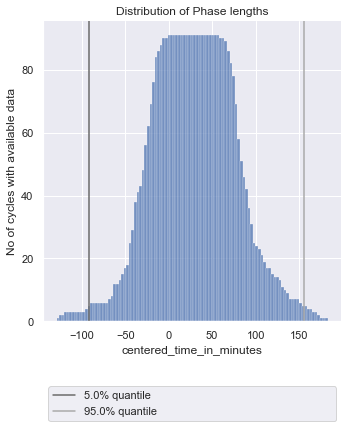

In [35]:
plot_data6['centered_time_in_minutes'] = plot_data6.centered_frames_in_phase * frame_interval_minutes
sns.displot(
    height=5,
    data=plot_data6,
    x='centered_time_in_minutes',
    bins=len(plot_data6.centered_frames_in_phase.unique())
)
plt.title('Distribution of Phase lengths')
plt.axvline(x=min_val, color='dimgray', label=f'{down_q*100}% quantile')
plt.axvline(x=max_val, color='darkgray', label=f'{upper_q*100}% quantile')
plt.legend(mode='expand', bbox_to_anchor=(0., -0.3, 1., 0.102))
plt.ylabel('No of cycles with available data')
plt.show()
selection_indices = np.logical_and(
    plot_data6.min_centered_frames*frame_interval_minutes>=min_val, 
    plot_data6.max_centered_frames*frame_interval_minutes<=max_val
)
plot_data6 = plot_data6[selection_indices]
standard_grouped = plot_data6.groupby(
    ['position', 'file', 'Cell_ID', 'generation_num']
).agg('count').reset_index()
plot_data6['Generation'] = plot_data6.apply(
    lambda x: f'1st ($n_1$={len(standard_grouped[standard_grouped.generation_num==1])})' if\
    x.loc['generation_num']==1 else f'2+ ($n_2$={len(standard_grouped[standard_grouped.generation_num>1])})',
    axis=1
)

# finally prepare data for plot (use melt for multiple lines)
sample_size = len(standard_grouped)
avg_cell_cycle_length = round(standard_grouped.loc[:,'centered_time_in_minutes'].mean())*frame_interval_minutes
cols_to_plot = ['Bud Signal', 'Combined Signal M&B']
index_cols = [col for col in plot_data6.columns if col not in cols_to_plot]
plot_data6_melted = pd.melt(
    plot_data6, index_cols, var_name='Method of Calculation'
).sort_values('Method of Calculation')

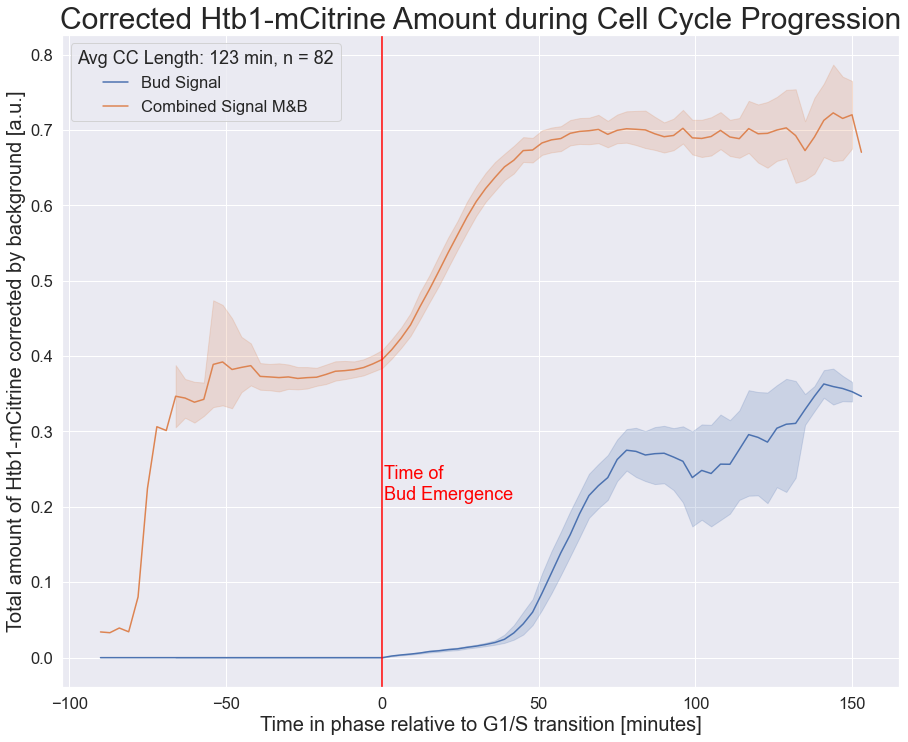

In [38]:
# plot the data, comment out "style" argument to not make difference between generations
sns.set_theme(style="darkgrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(15, 12))
ax = sns.lineplot(
    data=plot_data6_melted,#.sort_values('Pool, Phase'),
    x="centered_time_in_minutes", 
    y="value",
    hue='Method of Calculation',
    #style='Generation',
    ci=95
)
ax.axvline(x=0, color='red')#, label='Time of Bud Emergence')
ax.text(
    0.5, 0.21, "Time of \nBud Emergence", horizontalalignment='left', 
    size='medium', color='red', weight='normal'
)
#ax.axvline(x=min_val, color='darkgray', label=f'{down_q*100}%-quantile (G1 phase length)')
#ax.axvline(x=max_val, color='dimgray', label=f'{upper_q*100}%-quantile (S phase length)')
ax.legend(
    title=f'Avg CC Length: {avg_cell_cycle_length} min, n = {sample_size}', 
    fancybox=True,
    labelspacing=0.5,
    handlelength=1.5
)
#plt.setp(ax.get_legend().get_title(), fontsize='20') 
ax.set_ylabel("Total amount of Htb1-mCitrine corrected by background [a.u.]", fontsize=20)
ax.set_xlabel("Time in phase relative to G1/S transition [minutes]", fontsize=20)
ax.set_title("Corrected Htb1-mCitrine Amount during Cell Cycle Progression", fontsize=30)
#ax.set_yscale('log', base=2)
"""
plt.savefig(
    os.path.join('..', 'figures', 'mCitrine_over_time_v2.pdf'),
    dpi=300
)
"""
plt.show()

## Volume at birth and division vs. mCitrine amount at birth (single cell) and division (combined)

In [375]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
needed_cols = [
    'Cell_ID', 'generation_num', 'position', 'file', 'cell_cycle_stage', 'selection_subset', 
    'phase_volume_at_beginning', 'phase_volume_at_end', 'phase_mCitrine_amount_at_beginning',
    'phase_mCitrine_amount_comb_end', 'phase_volume_at_end_combined'
]
plot_data4 = phase_grouped.loc[phase_grouped.complete_cycle==1, needed_cols]

In [411]:
plot_data4['relevant_volume'] = plot_data4.apply(
    lambda x: x.loc['phase_volume_at_beginning'] if\
    x.loc['cell_cycle_stage']=='G1' else\
    x.loc['phase_volume_at_end_combined'],
    axis=1
)
plot_data4['relevant_amount'] = plot_data4.apply(
    lambda x: x.loc['phase_mCitrine_amount_at_beginning'] if\
    x.loc['cell_cycle_stage']=='G1' else\
    x.loc['phase_mCitrine_amount_comb_end'],
    axis=1
)
plot_data4['Kind of Measurement'] = plot_data4.apply(
    lambda x: 'Single Cell in G1 (Frame after Cytokinesis)' if\
    x.loc['cell_cycle_stage']=='G1' else\
    'Combined Mother & Bud in S (Frame before Cytokinesis)',
    axis=1
)
plot_data4['Generation'] = plot_data4.apply(
    lambda x: f'1st ($n_1$={int(len(plot_data4[plot_data4.generation_num==1])/2)})' if\
    x.loc['generation_num']==1 else f'2+ ($n_2$={int(len(plot_data4[plot_data4.generation_num>1])/2)})',
    axis=1
)

sample_size = len(plot_data4)

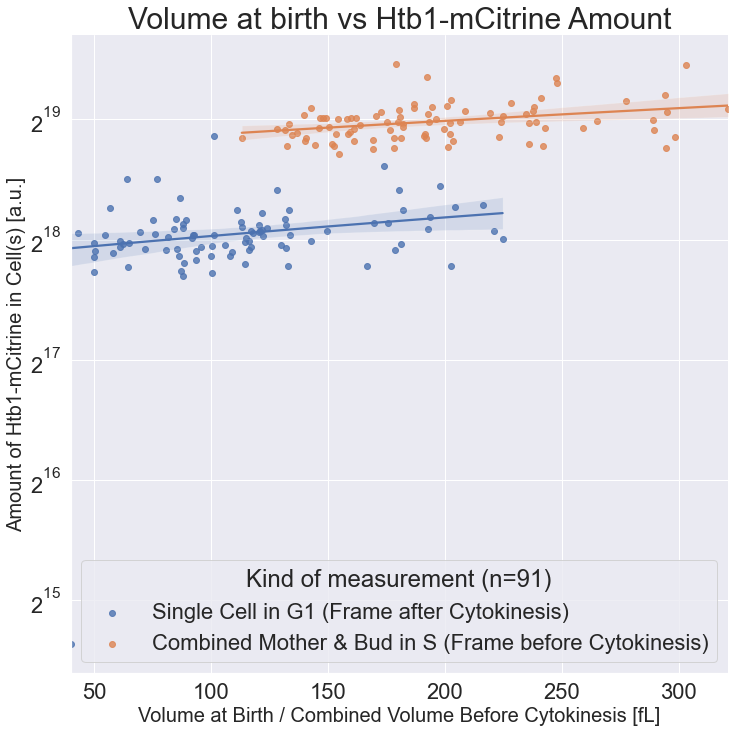

In [413]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(
    x="relevant_volume", 
    y="relevant_amount", 
    data=plot_data4,
    hue="Kind of Measurement",
    legend=False,
    #style="generation_num",
    height=10,
    aspect=1.1
)
#g._legend.set_title('Kind of Measurement')
ax = plt.gca()
#ax.set(yscale="log2")
ax.set_yscale('log', base=2)
#ax.set_xscale('log', base=2)
ax.legend(title=f'Kind of measurement (n={int(sample_size/2)})', loc='lower right')
ax.set_ylabel("Amount of Htb1-mCitrine in Cell(s) [a.u.]", fontsize=20)
ax.set_xlabel("Volume at Birth / Combined Volume Before Cytokinesis [fL]", fontsize=20)
ax.set_title("Volume at birth vs Htb1-mCitrine Amount", fontsize=30)
plt.savefig(
    os.path.join('..', 'figures', 'mCitrine_at_birth_and_cytokinesis_v1.pdf'),
    dpi=300
)
plt.show()

# Plot gallery

## (Volume) growth in G1 vs. mother+daughter growth in S (1st generation)

In [ ]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data2 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner')
plot_data2 = plot_data2[plot_data2.generation_num==1]
plot_data2['combined_motherbud_growth'] = plot_data2['growth_in_phase_y'] + plot_data2['daughter_area_growth_y']
plot_data2['combined_motherbud_vol_growth'] = plot_data2['volume_growth_in_phase_y'] + plot_data2['daughter_volume_growth_y']

In [ ]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="growth_in_phase_x", y="combined_motherbud_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S growth [pixel area]", fontsize=20)
ax.set_xlabel("G1 growth [pixel area]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth (area)", fontsize=30)
plt.show()

In [ ]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_growth_in_phase_x", y="combined_motherbud_vol_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S volume growth [fl]", fontsize=20)
ax.set_xlabel("G1 volume growth [fl]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth (Volume)", fontsize=30)
plt.show()

## Area and Volume at birth vs. G1 duration (1st generation)

In [107]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data3 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data3 = plot_data3[plot_data3.incomplete_phase==0]
plot_data3 = plot_data3[plot_data3.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Area at birth (first cytokinesis)", fontsize=20)
ax.set_title("Area at birth vs G1 duration (1st generation)", fontsize=30)
plt.show()

KeyError: "['selection_subset', 'area_at_beginning'] not in index"

In [108]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis) [fL]", fontsize=20)
ax.set_title("Volume at birth vs G1 duration (1st generation)", fontsize=30)
plt.show()

KeyError: "['selection_subset', 'volume_at_beginning'] not in index"

## Area and Volume at birth vs. mCitrine concentration at birth (1st generation)

In [ ]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data4 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data4 = plot_data4[plot_data4.incomplete_phase==0]
plot_data4 = plot_data4[plot_data4.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="area_at_beginning", y="mCitrine_concentration_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
g.set(yscale="log")
ax = plt.gca()
ax.set_ylabel("mCitrine concentration in cell [a.u.]", fontsize=20)
ax.set_xlabel("Area at birth (first cytokinesis)", fontsize=20)
ax.set_title("Area at birth vs mCitrine concentration (1st generation)", fontsize=30)
plt.show()

In [ ]:
sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="volume_at_beginning", y="mCitrine_concentration_at_beginning", data=plot_data4,
    hue="selection_subset", height=10, )
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylabel("mCitrine concentration in cell [a.u.]", fontsize=20)
ax.set_xlabel("Volume at birth (first cytokinesis)", fontsize=20)
ax.set_title("Volume at birth vs mCitrine concentration (1st generation)", fontsize=30)
plt.show()

## G1 vs. S duration (1st generation)

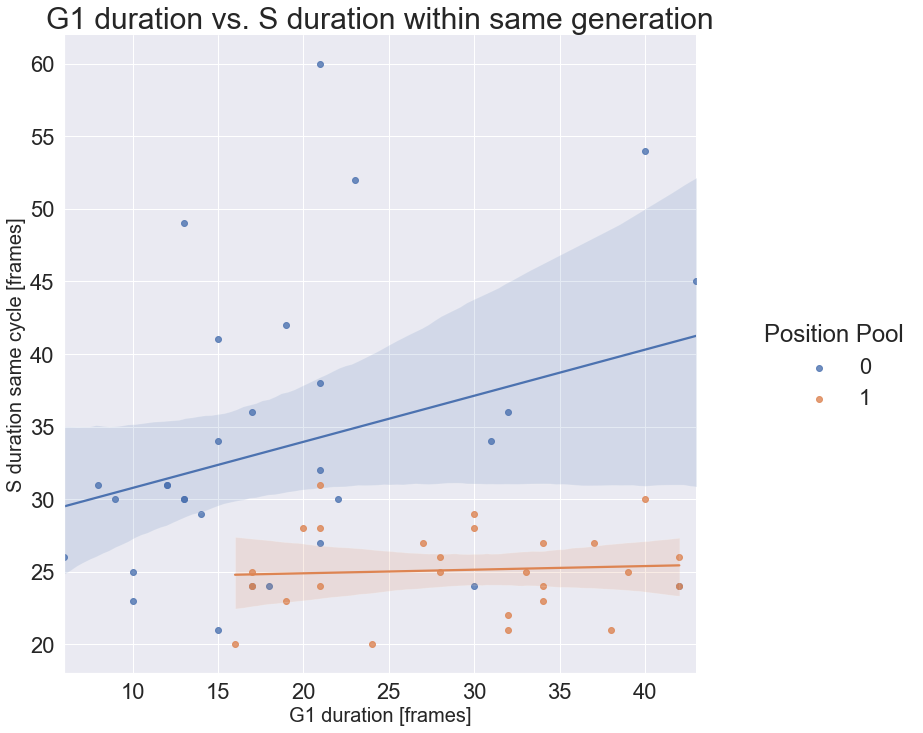

In [31]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data1 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position', 'file'], how='inner')
plot_data1 = plot_data1[plot_data1.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
g = sns.lmplot(x="phase_length_x", y="phase_length_y", data=plot_data1,
    hue="selection_subset_x", height=10)
g._legend.set_title('Position Pool')
ax = plt.gca()
ax.set_ylabel("S duration same cycle [frames]", fontsize=20)
ax.set_xlabel("G1 duration [frames]", fontsize=20)
ax.set_title("G1 duration vs. S duration within same generation", fontsize=30)
plt.show()

# backup

## Flurescence Signal vs. relative time in phase

In [164]:
needed_cols = [
    'selection_subset', 'position', 'Cell_ID', 'cell_cycle_stage', 'generation_num', 'frame_i',
    'mCitrine_corrected_mean_signal', 'mCitrine_corrected_signal_amount', 'file', 'relationship'
]
plot_data5 = overall_df[needed_cols].copy()
plot_data5['frames_in_phase'] = plot_data5.sort_values(['frame_i'], ascending=True)\
             .groupby(['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'file', 'selection_subset'])\
             .cumcount() + 1

phase_lengths = plot_data5.groupby(
    ['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'selection_subset']
).agg(phase_length=('frame_i', lambda x: max(x)-min(x)+1)).reset_index()
plot_data5 = plot_data5.merge(
    phase_lengths, 
    on=['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'selection_subset'],
    how='left'
)
plot_data5['relative_time_in_phase'] = plot_data5['frames_in_phase']/plot_data5['phase_length']
plot_data5['Pool, Phase, Type'] = plot_data5.apply(
    lambda x: f'Pool {str(x.loc["selection_subset"])}, Phase {x.loc["cell_cycle_stage"]}, Type {x.loc["relationship"]}', axis=1
)

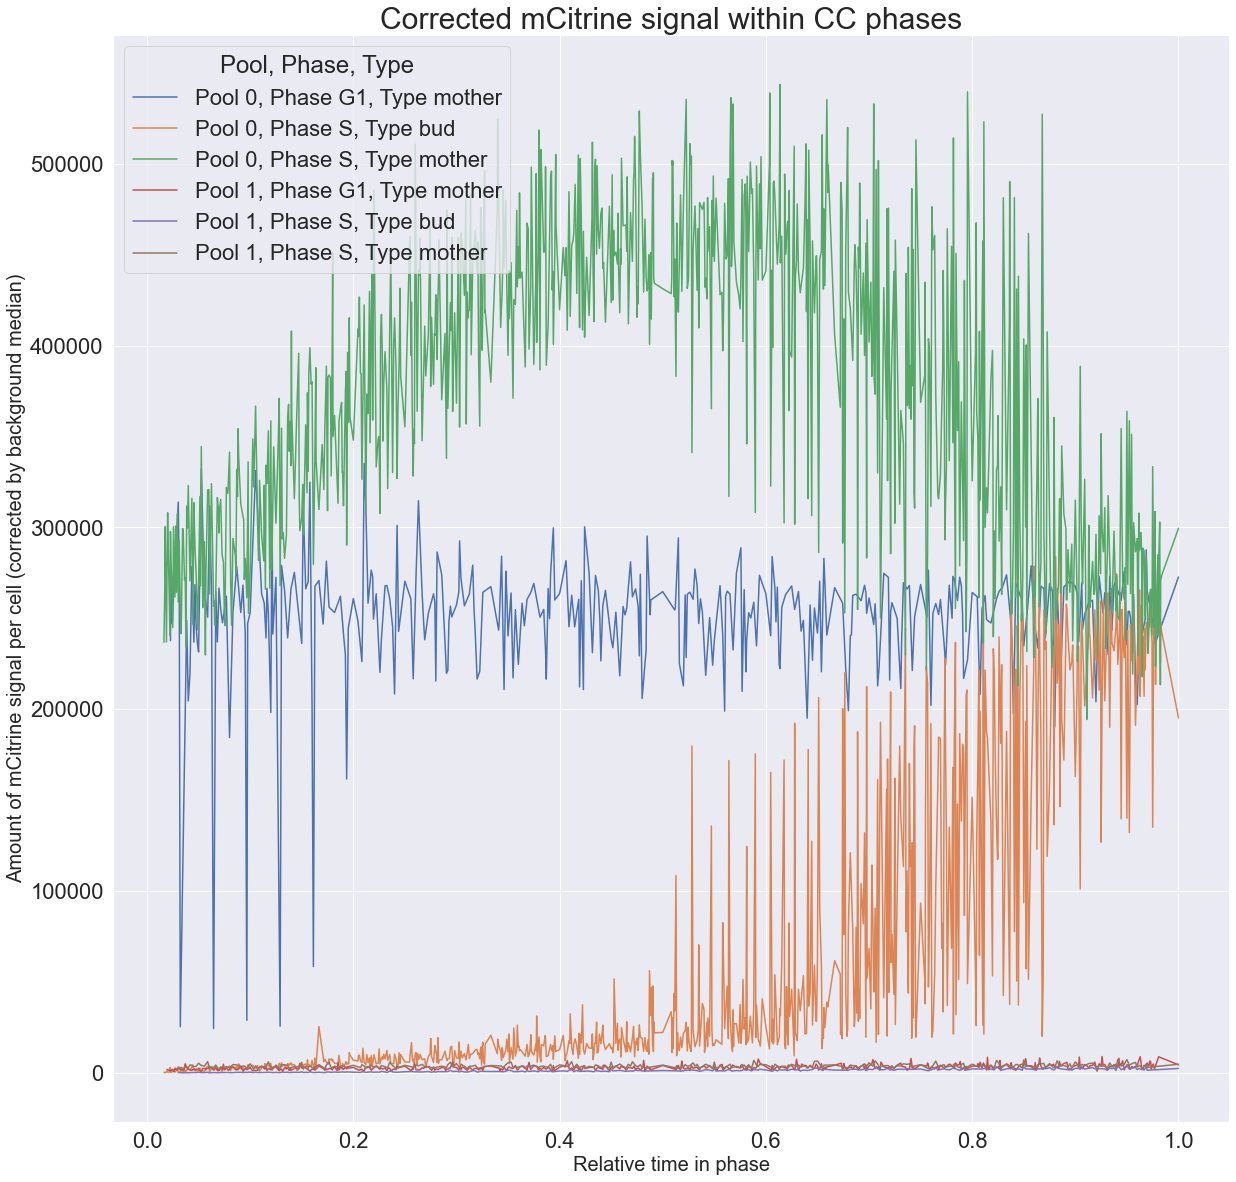

In [165]:
sns.set_theme(style="darkgrid", font_scale=2)
f, ax = plt.subplots(figsize=(20, 20))
sns.lineplot(data=plot_data5.sort_values('Pool, Phase, Type'), x="relative_time_in_phase", y="mCitrine_corrected_signal_amount", 
             hue='Pool, Phase, Type', ci=None)
ax.set_ylabel("Amount of mCitrine signal per cell (corrected by background median)", fontsize=20)
ax.set_xlabel("Relative time in phase", fontsize=20)
ax.set_title("Corrected mCitrine signal within CC phases", fontsize=30)
plt.show()

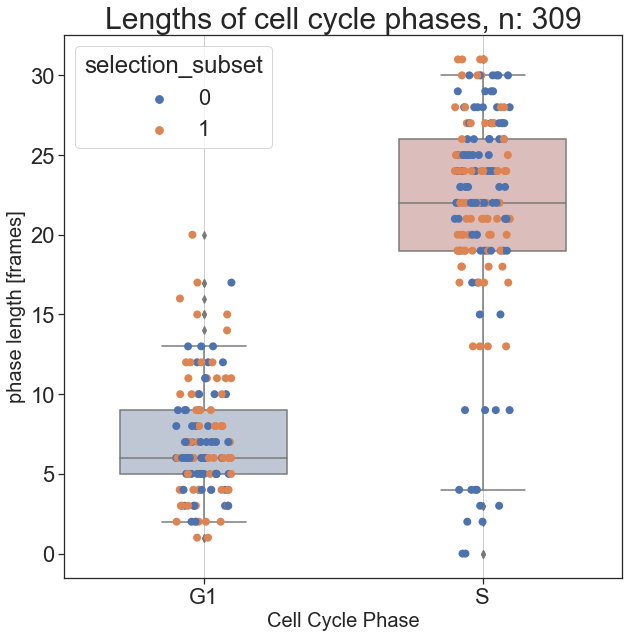

In [69]:
plot_data1 = phase_grouped[~incomplete_phase_indices]
sns.set_theme(style="ticks", font_scale=2)

# Initialize the figure
f, ax = plt.subplots(figsize=(10, 10))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
            whis=[5, 95], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
              size=8, hue="selection_subset", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set_ylabel("phase length [frames]", fontsize=20)
ax.set_xlabel("Cell Cycle Phase", fontsize=20)
ax.set_title(f"Lengths of cell cycle phases, n: {plot_data1.shape[0]}", fontsize=30)
#sns.despine(trim=True, left=True)
plt.show()

In [144]:
# code for calculating column "phase transition (boolean)"
"""
plot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)

plot_data3['phase_transition'] = 0
for i in plot_data3.cell_pos_id.unique():
    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]
    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)
    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1
    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data
"""

"\nplot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)\n\nplot_data3['phase_transition'] = 0\nfor i in plot_data3.cell_pos_id.unique():\n    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]\n    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)\n    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1\n    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data\n"

### alternatively configure stuff manually

In [24]:
# the path to the data folder containing the MIA_ folders
data_dir = os.path.join('..', 'data', 'nd2_files')
# the MIA_ folder which should be analyzed
mia_dir = 'MIA_F016.nd2'
# the positions which should be incorporated in the analysis
positions = [6]
# channels to incorporate in the Analysis, assuming to be the same for all positions
channels = ['phase_contr', 'mCitrine']